In [1]:
# basic DS imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# time series imports
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import Holt
from prophet import Prophet

# custom function imports
from acquire import *
from explore import *
from model import *

# shhhh (clean report without notifications of plot size issues, etc.)
import warnings
warnings.filterwarnings("ignore")

---

#### Planning
Goal:
- Project Objective: Use Time Series Predictions to Predict the Weather for Seoul, South Korea. Predicting a year.

Deliverables:
- acquire.py : Functions to reproduce Acquiring and Cleaning of Data.
- explore.py : Functions to reproduce Exploring the Data.
- model.py : Functions to reproduce Modeling the Data.
- Final Notebook (ipynb) : Notebook with steps to reproduce. 

**Recreation Note**: I do use fb Prophet in my notebook, you will have to *pip install prophet* if you don't have it yourself.

---
#### Data Acquisition and Data Preparations
Using our acquire.py, we'll Acquire the data from the .csv downloaded from (https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data), we utilize the following two .csv from it:
- GlobalLandTemperaturesByCountry.csv
- GlobalLandTemperaturesByMajorCity.csv

Our function will remove the null rows, convert the dt column from object to datetime, set the index to dt, drop irrelevent columns, rename columns for joining, and joins dataframes together.

As well as, plot the mean of seoul average temp and south_korea average temp at 1 month, 3 months, 6 months, and a year.

Then add a difference column, that takes the difference between the South Korean Average with the Seoul Average.
Before returning the Data Frames left joined on index.

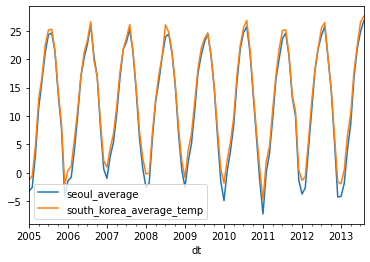

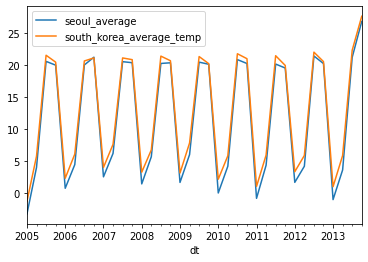

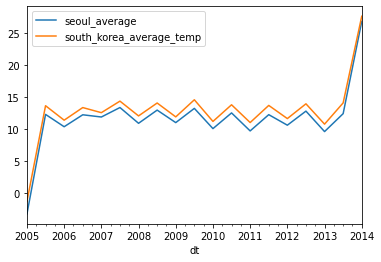

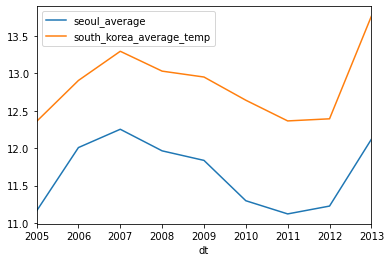

In [2]:
# getting the joined data frames for Seoul and all of South Korea plus the difference in temperature. And some charts showing 1 month, 3 months, 6 months, and 1 year means.
df = wrangle_seoul()

In [3]:
# A peek at our DataFrame
df.head()

,seoul_average,south_korea_average_temp,difference
dt,,,
2005-01-01,-3.260,-1.312,1.948
2005-02-01,-2.614,-0.589,2.025
2005-03-01,3.197,4.777,1.580
2005-04-01,11.411,13.071,1.660
2005-05-01,16.160,16.877,0.717


In [4]:
# checking the stats with .describe()
df.describe()

,seoul_average,south_korea_average_temp,difference
count,104.000000,104.000000,104.000000
mean,11.648019,12.819087,1.171067
std,10.036293,9.489136,0.749039
min,-7.279000,-4.818000,-0.722000
25%,3.109000,4.570750,0.630250
50%,12.981500,13.394500,1.166500
75%,21.125500,21.640250,1.739750
max,26.791000,27.601000,3.083000


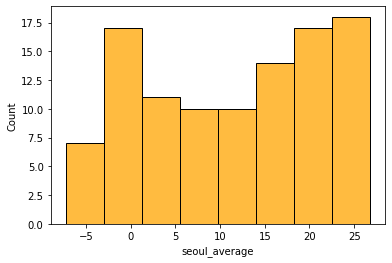

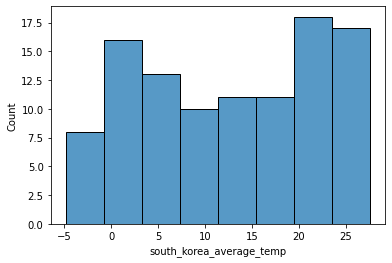

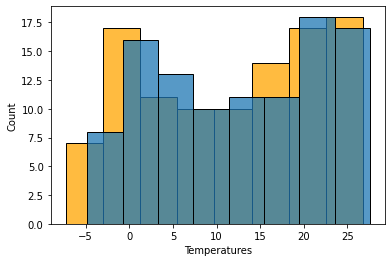

In [5]:
# Now Histograms of Seoul's temp and South Korea's Temp
histoplots(df)

##### Summary:
Data Cleaned, Scaled, and Charted. The Average for Seoul is very similar to South Korea as a whole, except Seoul is slightly colder. So, We'll predict Seoul, South Korea, and the Difference in the long run.

---

#### Data Exploration

Splitting the Data into train, validate, and test before starting some exploration.

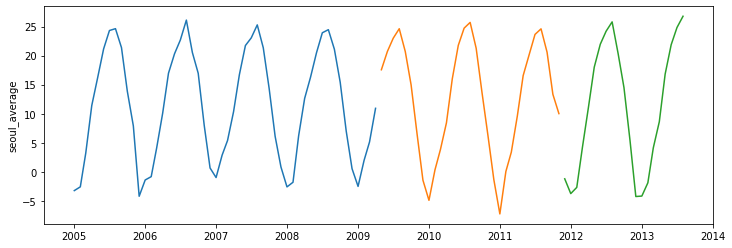

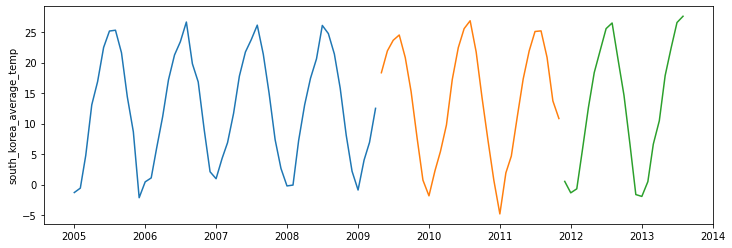

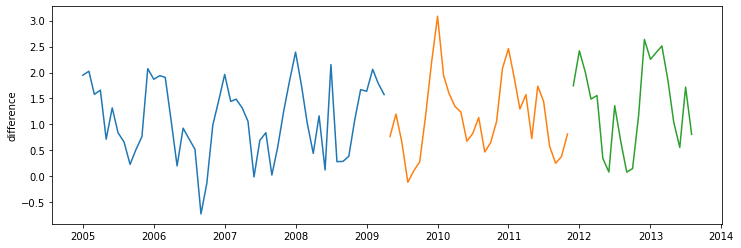

In [6]:
# split the data
train, validate, test = split(df)

How Correlated are the temperatures in Seoul, and the temperatures in Korea as a whole?

- H0: There is no correlation between Temperatures in Seoul and Temperatures in South Korea.
- Ha: There is a correlation between Temperatures in Seoul and Temperatures in South Korea.

Correlation : 0.9986328749191393
    p-value : 9.212700035670795e-66


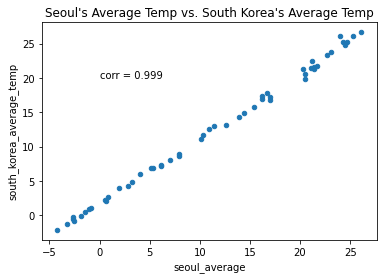

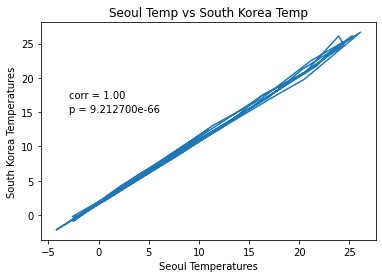

In [7]:
# Pearson's Correlation Coefficient test and visualizations:
corr, p = correlation(train)

Even with the few degree difference, there's definitely a correlation. While **we reject the Null Hypothosis**, The study most likely used Seoul's reading to conpute part of South Korea's temperatures as a whole. With the relatively small area of South Korea a likely factor as well, placing most of the readings around gernerally the same longitude and latitude.

We'll Look at Month and Year distributions of temperatures for both Seoul and South Korea, as well as seasonality. With Y being actual temperatures from train.

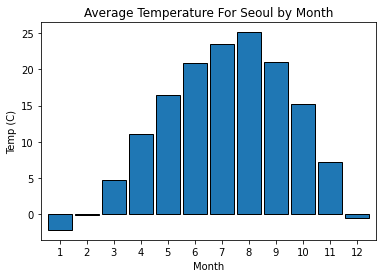

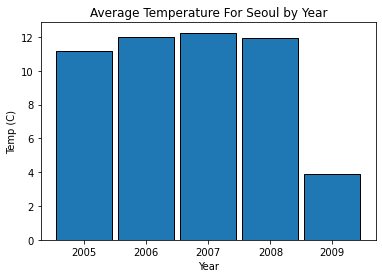

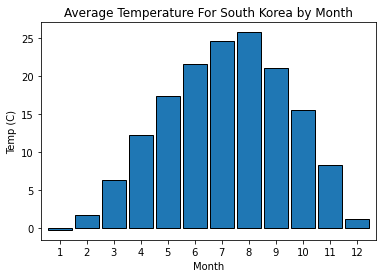

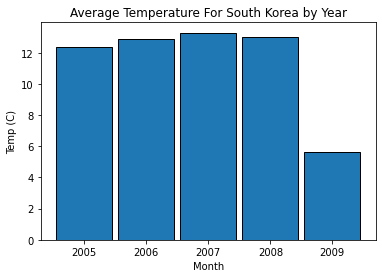

Seoul Seasonality Decomposition:
                 y  trend   seasonal  resid
dt                                         
2005-01-01  -3.260    NaN -13.631686    NaN
2005-02-01  -2.614    NaN -11.880505    NaN
2005-03-01   3.197    NaN  -6.717075    NaN
2005-04-01  11.411    NaN  -0.928283    NaN
2005-05-01  16.160    NaN   4.695009    NaN
-------
South Korea Seasonality Decomposition:
                 y  trend   seasonal  resid
dt                                         
2005-01-01  -1.312    NaN -12.545288    NaN
2005-02-01  -0.589    NaN -11.176080    NaN
2005-03-01   4.777    NaN  -6.241205    NaN
2005-04-01  13.071    NaN  -0.984760    NaN
2005-05-01  16.877    NaN   4.505740    NaN


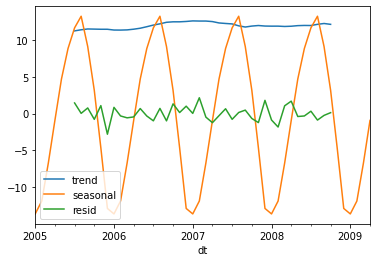

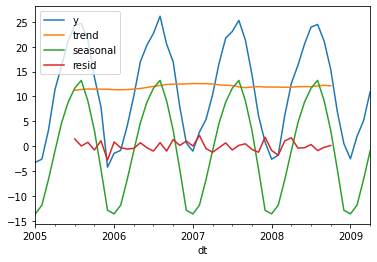

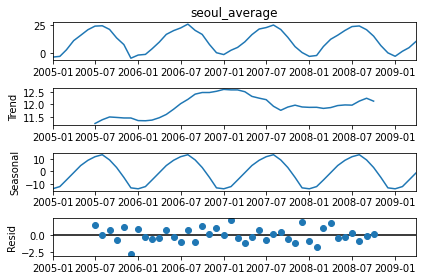

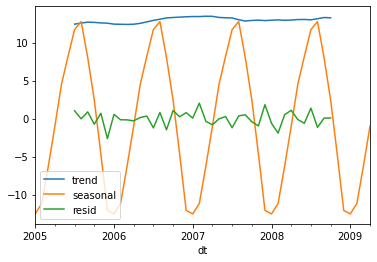

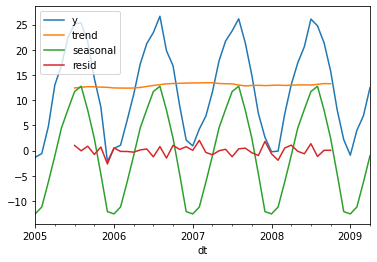

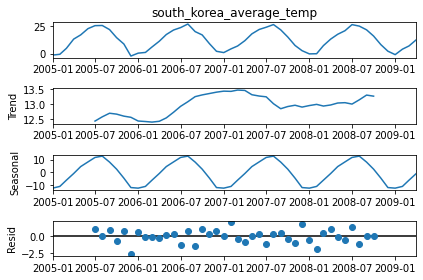

In [8]:
# splitting train into y (actual temps) Dataframes. Visualizing Monthly and Yearly Average Temperatures. 
# Then Decomposing to look at seasonality.
y_tests(train)

Seoul and South Korea are both defintely seasonal yearly with the average around 12(C) and 13(C) respectively. The temperatures appear to be fairly consistent between years as well. Only 2009 looks different, but that's because we're only viewing about 1/4th of the year.

Let's see how similar the temperatures really are to each other yearly. 

We'll start with an ANOVA test for Seoul, since we want to predict the weather there. Let's look at years first.

- H0: There is No Difference between yearly temperatures in Seoul.
- Ha: There is a significant difference between yearly temperatures in Seoul.

###### We won't be using the 2009 data we have as it's incomplete.

In [9]:
# Significance level set to 0.05, Distribution is normal looking at each month in the year.
# Checking for normal variance:
yearly_var(train)

We can reject the Null Hypothesis. The groups appear to have different variances


That actually was unexpected. We'll have to go about using a 2-sample, independent T-Test. We'll test each year to its previous and next year. 

Hypothesis revamp:
- H0: 2006's yearly average equals 2005's yearly average
- Ha: 2006's yearly average does not equal 2005's yearly average

In [10]:
# We'll look at 2005 vs 2006 first.
# Running a 2-Sample, Independent T-Test
ttest_five_six(train)

We cannot reject the Null Hypothosis, there is little to no significant difference.


So, the average temp for 2005 and 2006 don't have a significant difference, let's check for 2006 and and 2007

- H0: 2006's yearly average equals 2007's yearly average
- Ha: 2006's yearly average does not equal 2007's yearly average

In [11]:
# Now a 2-Sample, Independent T-Test for 2006 and 2007
ttest_six_seven(train)

We cannot reject the Null Hypothosis, there is little to no significant difference.


Again, 2006 and 2007 have no significant difference. On to checking 2007 against 2008.

- H0: 2007's yearly average equals 2008's yearly average
- Ha: 2007's yearly average does not equal 2008's yearly average

In [12]:
# Lastyly 2007 and 2008 2-Sample, Independent T-Test
ttest_seven_eight(train)

We cannot reject the Null Hypothosis, there is little to no significant difference.


2007 also has no significant difference to 2008.

Conclusion: The Previous Year can mostlikely be used to Predict the Coming Year within the 95% confidence level.

---------

#### Modeling

We're going to try out Holt's Linear Trend, Previous Cycle, and Facebook's Prophet Model
- Holt's Linear trend : Looks like it might form a line with an arch to fit the trend we've seen with seasonality
- Previous Cycle : We saw that previous and future years have little to no significant difference, so this is a promising model.
- Facebook's Prophet seems to not only predict curve and seasonality, but also an increase of the mean values linearly.

In [13]:
# Creating our DataFrames for predictions and Evaluation.
yhat = create_yhat(train, validate)
eval_df = create_eval()

##### Holt's Linear Trend

seoul_average -- RMSE: 15


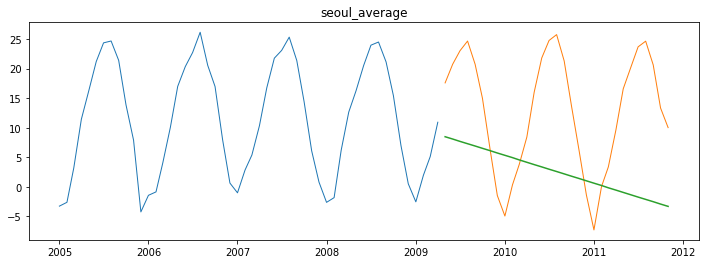

south_korea_average_temp -- RMSE: 14


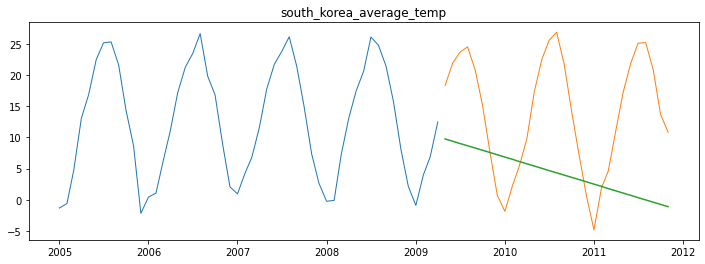

difference -- RMSE: 1


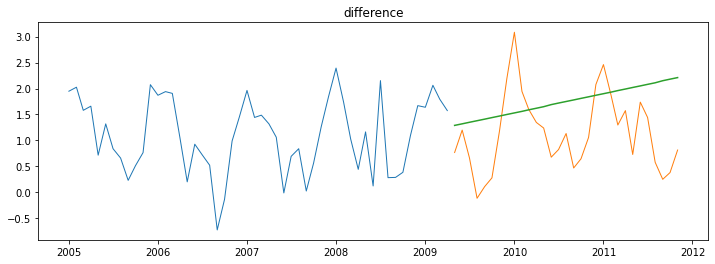

  model_type                target_var  rmse
0      Holts             seoul_average  15.0
1      Holts  south_korea_average_temp  14.0
2      Holts                difference   1.0


In [14]:
# Creating, fitting and predicting with the model.
yhat, eval_df = holts_model(train, validate, yhat, eval_df)

Not the greatest, and not really what I expected.

##### Previous Cycle
Moving on, I have more hope for this model given our stats tests.

seoul_average -- RMSE: 2


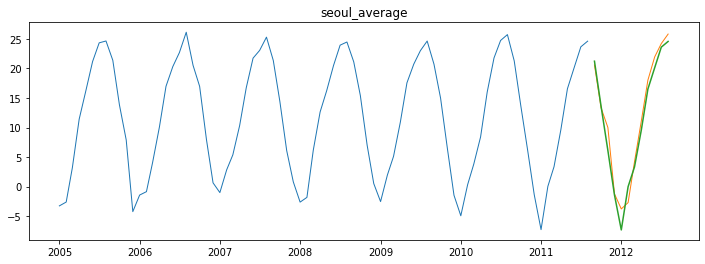

south_korea_average_temp -- RMSE: 2


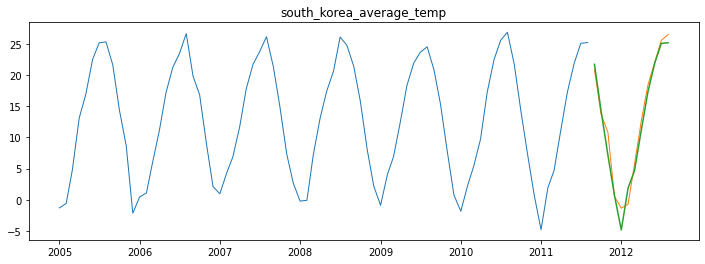

difference -- RMSE: 1


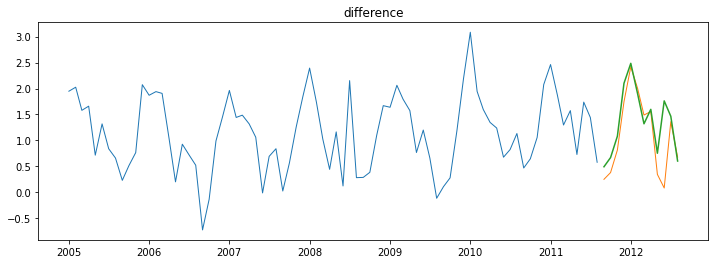

      model_type                target_var  rmse
0          Holts             seoul_average  15.0
1          Holts  south_korea_average_temp  14.0
2          Holts                difference   1.0
3  previous year             seoul_average   2.0
4  previous year  south_korea_average_temp   2.0
5  previous year                difference   1.0


In [15]:
train_pre, validate_pre, test_pre, yhat_df, eval_df = prev_cycle(df, eval_df)

This seems to be a much more accurate prediction of what the next year will look like.

##### Prophet

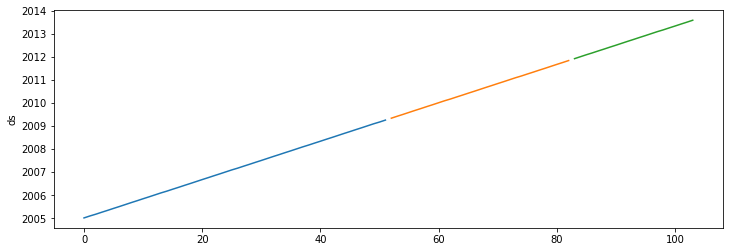

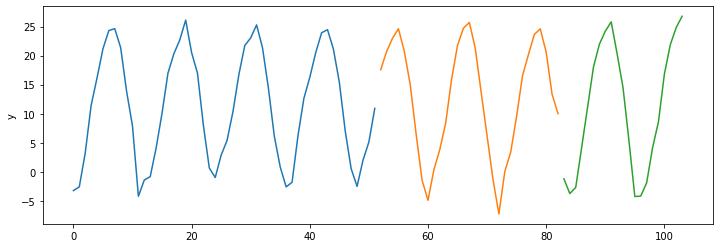

08:58:06 - cmdstanpy - INFO - Chain [1] start processing
08:58:06 - cmdstanpy - INFO - Chain [1] done processing


           ds       yhat  yhat_lower  yhat_upper
49 2009-02-01   0.381103   -0.877622    1.619564
50 2009-03-01   5.168747    3.863983    6.483971
51 2009-04-01  11.673879   10.398674   12.948730
52 2009-05-01  16.783604   15.493731   18.037667
53 2009-06-01  21.169364   19.836816   22.391224
54 2009-07-01  24.109079   22.823568   25.460794
55 2009-08-01  25.333811   23.951174   26.581625
56 2009-09-01  21.494375   20.274067   22.749255
57 2009-10-01  15.537388   14.194387   16.831103
58 2009-11-01   7.722353    6.425244    9.041476
59 2009-12-01  -0.537625   -1.721087    0.796785
60 2010-01-01  -1.727584   -2.925693   -0.461776
61 2010-02-01   0.377017   -0.815202    1.575557
62 2010-03-01   5.214356    3.952103    6.605668
63 2010-04-01  11.130318    9.914243   12.374987


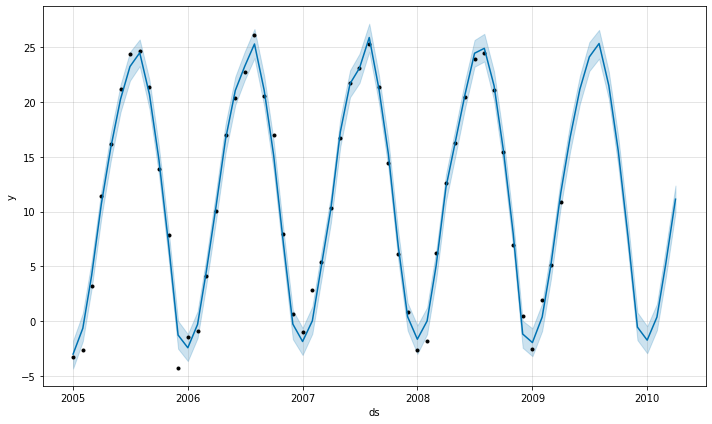

In [16]:
train_p, validarte_p, test_p = fb_prophet(df)

##### Prophet Takeaway:
While I really like what Prophet is doing, I don't understand it well enough to check its predictions in any meaningful way.

Looking at Cross Validations, there might not be a work around to only having month and year vs. day month and year that Cross Validations wants.

There is a Monthly Data section I'll have to read back on when project isn't due.